<a href="https://colab.research.google.com/github/amitsangani/Llama/blob/main/Llama_3_2_Multimodal%2C_Stack%2C_Tool_Calling_and_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

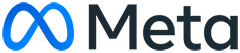

# **Building with Multimodel Llama 3.2**

# Overview

Multimodal, Llama Stack and smaller models are the 3 major announcements in [Llama 3.2](https://www.llama.com/). In this workstop, we'll cover multimodal Llama 3.2, Tool calling, Llama Stack and RAG. In this notebook, we will walk through 4 major areas of Llama 3.2:
1. Multimodal Llama 3.2
2. Tool Calling
3. Llama Stack Demo
4. RAG using web documents and PDF

# Multimodal Llama 3.2

This section shows 7 multimodal use cases that can be evolved into full production apps.

First we define a helper function llama32 which accepts a list of messages and the model size, default to the 3.2 11B but can also use 90B if passed as 90.

In [ ]:
import requests
import json

from google.colab import userdata
import os
os.environ['TOGETHER_API_KEY'] = userdata.get('TOGETHER_API_KEY')

def llama32(messages, model_size=11):
  model = f"meta-llama/Llama-3.2-{model_size}B-Vision-Instruct-Turbo"
  url = "https://api.together.xyz/v1/chat/completions"
  payload = {
    "model": model,
    "max_tokens": 4096,
    "temperature": 0.0,
    "stop": ["<|eot_id|>","<|eom_id|>"],
    "messages": messages
  }

  headers = {
    "Accept": "application/json",
    "Content-Type": "application/json",
    "Authorization": "Bearer " + os.environ["TOGETHER_API_KEY"]
  }
  res = json.loads(requests.request("POST", url, headers=headers, data=json.dumps(payload)).content)

  if 'error' in res:
    raise Exception(res['error'])

  return res['choices'][0]['message']['content']

Next are two helpers that display a local image and remote image.

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import requests
from io import BytesIO

# displays local image given a path
def display_local_image(path):
  img = Image.open(path)
  plt.imshow(img)
  plt.axis('off')
  plt.show()

# displays remote image given a URL
def display_image_url(url):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Finally, another helper llama32pi that accepts a raw prompt and an image url.

In [ ]:
def llama32pi(prompt, image_url, model_size=90):
  display_image_url(image_url)
  messages = [
    {
      "role": "user",
      "content": [
        {
          "type": "text",
          "text": prompt
        },
        {
          "type": "image_url",
          "image_url": {
            "url": image_url
          }
        }
      ]
    },
  ]

  result = llama32(messages, model_size)
  return result


## Image captioning

In [ ]:
print(llama32pi("describe the image in one sentence", "https://images.news18.com/ibnlive/uploads/2023/11/untitled-design-9-2023-11-95acc557353b153d9fd9e074fc345786.png?impolicy=website&width=640&height=480"))


## OCR on nutrition facts

In [ ]:
print(llama32pi("Which drink should one drink? After the answer, also generete nurtrition facts of the two drinks in JSON format for easy comparison.",
                "https://raw.githubusercontent.com/jeffxtang/llama-stack-apps/refs/heads/main/examples/drinks.png"))

## Understanding and implementing diagram in Llama 3 paper

In [ ]:
print(llama32pi("I see this diagram in the Llama 3 paper. Summarize the flow in text and then return a python script that implements the flow.",
                "https://raw.githubusercontent.com/jeffxtang/llama-stack-apps/refs/heads/main/examples/llama32mm.png"))

## Dog breed recognition

In [ ]:
print(llama32pi("What dog breed is this? Tell me in one sentence about the breed.",
                "https://raw.githubusercontent.com/jeffxtang/llama-stack-apps/refs/heads/main/examples/ww2.png"))


## Kid's math grader

In [ ]:
prompt = """
Check carefully each answer in a kid's math homework.
First calculate the correct answer for each problem.
Then return the the kid's answers.
Finally return a total grade."""

print(llama32pi(prompt, f"https://raw.githubusercontent.com/jeffxtang/llama-stack-apps/refs/heads/main/examples/math_hw1.jpg"))

In [ ]:
prompt = """
Return the kid's answers for all the math problems in the question below.
Then calculate the correct answer for each problem.
Finally compare kid's answers with the correct answers, and return the grade.
"""

print(llama32pi(prompt, f"https://raw.githubusercontent.com/jeffxtang/llama-stack-apps/refs/heads/main/examples/math_hw1.jpg"))

In [ ]:
prompt = """
Check carefully each answer in a kid's math homework, first do the calculation, then compare the result with the kid's answer,
mark correct or incorrect for each answer, and finally return a total score based on all the problems answered."""

print(llama32pi(prompt, f"https://raw.githubusercontent.com/jeffxtang/llama-stack-apps/refs/heads/main/examples/math_hw2.jpg"))

## Books on the shelf

In [ ]:
prompt = """
Return all the book titles with author names in the bookshelf, first the top shelf from left to right, then the bottom shelf the same order."""

print(llama32pi(prompt, f"https://raw.githubusercontent.com/jeffxtang/llama-stack-apps/refs/heads/main/examples/bookshelf2.png"))

## Money in the receipts

In [ ]:
prompt = "What's the total charge of all the recipts below?"

response = llama32pi(prompt, f"https://raw.githubusercontent.com/jeffxtang/llama-stack-apps/refs/heads/main/examples/receipts.jpg")
print(response)

# Tool calling in Llama 3.2

Llama 3.2 (and 3.1) supports three built-in tools:

1. Brave Web Search: Tool call to perform web searches.
2. Wolfram Alpha: Tool call to perform complex mathematical calculations.
3. Code Interpreter: Enables the model to output python code.

## The brave_search built-in tool

Web search tool is needed when the answer to the user question is beyond the LLM's knowledge cutoff date, e.g. current whether info or recent events. Llama 3.2 has a knowledge cutoff date of December 2023.

To see how Llama 3.2 responds to a user question "What is the current weather in Menlo Park, California?" with the system prompt above, run the code snippet:

In [ ]:
from datetime import datetime

current_date = datetime.now()
formatted_date = current_date.strftime("%d %B %Y")

messages = [
    {
      "role": "system",
      "content":  f"""
Environment: ipython
Tools: brave_search, wolfram_alpha
Cutting Knowledge Date: December 2023
Today Date: {formatted_date}
"""
      },
    {
      "role": "user",
      "content": "What is the current weather in Menlo Park, California?"
    }
  ]

response = llama32(messages)
print(response)

### Calling the search API

To ask Llama 3.2 for the final answer to your original question, you'll need to first make the actual search call and then pass the search result back to Llama 3.2. Even though the Llama 3.2 built in search tool name is `brave_search`, you can use any search API; in fact, because you'll need to enter your credit card info at the Brave Search site even to get a trial API key, we'll use Tavily Search, which you can get a free trial API key in seconds using your gmail or github account.



In [ ]:
!pip install -q tavily-python

In [ ]:
from tavily import TavilyClient

TAVILY_API_KEY = userdata.get('TAVILY_API_KEY')
tavily_client = TavilyClient(api_key=TAVILY_API_KEY)

result = tavily_client.search("current weather in Menlo Park, California")
result

In [ ]:
search_result = result["results"][0]["content"]
search_result

### Reprompting Llama with search tool response

With the tool call result ready, it's time to reprompt Llama 3.2, with all the info below added after the original prompt.


In [ ]:
messages = [
    {
      "role": "system",
      "content":  f"""
Environment: ipython
Tools: brave_search, wolfram_alpha
Cutting Knowledge Date: December 2023
Today Date: {formatted_date}
"""
      },
    {
      "role": "user",
      "content": "What is the current weather in Menlo Park, California?"
    },
    {
      "role": "assistant",
      "content": response
    },
    {
      "role": "ipython",
      "content": search_result
    }
  ]

response = llama32(messages)
print(response)

## The Wolfram Alpha tool

Wolfram Alpha is designed to handle certain types of complex and highly specific mathematical problems that might be challenging for LLMs to answer with complete accuracy. Examples of problems that Wolfram Alpha can answer correctly but an LLM might struggle with include:

* Symbolic Computation and Simplification
* High-Precision Arithmetic
* Complex Integrals and Derivatives
* Formal Proofs and Theorems
* Advanced Matrix Operations
* Multi-step Complex Calculations

So if you're building a Llama 3.2 math tutor in one or more of those problem domains, you'll likely need to use the Wolfram Alpha tool. The problem below may not need using the Wolfram Alpha tool by default, but you can hint in the prompt to ask Llama to try using the tool so to a more difficult problem you know how to use the Wolfram tool.

In [ ]:
math_problem = "Can you help me solve this equation: x^3 - 2x^2 - x + 2 = 0? try using tool"
messages = [
    {
      "role": "system",
      "content":  f"""
Environment: ipython
Tools: brave_search, wolfram_alpha
Cutting Knowledge Date: December 2023
Today Date: {formatted_date}
"""
      },
    {
      "role": "user",
      "content": math_problem
    }
  ]

response = llama32(messages)
print(response)

### Calling the Wolfram Alpha tool

In [ ]:
!pip install -q wolframalpha

In [ ]:
WOLFRAM_ALPHA_KEY = userdata.get('WOLFRAM_ALPHA_KEY')

from wolframalpha import Client
import nest_asyncio

nest_asyncio.apply()

def wolfram_alpha(query: str) -> str:
    client = Client(WOLFRAM_ALPHA_KEY)
    result = client.query(query)

    results = []
    for pod in result.pods:
        if pod["@title"] == "Result" or pod["@title"] == "Results":
          for sub in pod.subpods:
            results.append(sub.plaintext)

    return '\n'.join(results)

tool_result = wolfram_alpha("solve x^3 - 2x^2 - x + 2 = 0")
print(tool_result)


### Reprompting Llama with tool result

In [ ]:
messages = [
    {
      "role": "system",
      "content":  f"""
Environment: ipython
Tools: brave_search, wolfram_alpha
Cutting Knowledge Date: December 2023
Today Date: {formatted_date}
"""
      },
    {
      "role": "user",
      "content": math_problem
    },
    {
      "role": "assistant",
      "content": response
    },
    {
      "role": "ipython",
      "content": tool_result
    }
  ]

response = llama32(messages)
print(response)

## The code interpreter built-in tool

Just including `Environment: ipython` turns on the code interpreter tool so you don't need to specify the tool on the Tools: line. Let's now ask Llama a million dollar question: "How much is the monthly payment, total payment, and total interest paid for a 30 year mortgage of $1M at a fixed rate of 6% with a 20% down payment?" Note that you can replace "Python" in "Generate the code in Python." in the System prompt with another language such as "Java" to see the Java code to answer the question.

In [ ]:
prompt = """How much is the monthly payment, total payment,
    and total interest paid for a 30 year mortgage of $1M
    at a fixed rate of 6% with a 20% down payment?
    """

messages = [
    {
      "role": "system",
      "content":  f"""
Environment: ipython
Tools: brave_search, wolfram_alpha
Cutting Knowledge Date: December 2023
Today Date: {formatted_date}

Generate the code in Python.
"""
      },
    {
      "role": "user",
      "content": prompt
    },
  ]

response = llama32(messages)
print(response)


In [ ]:
loan_amount = 1000000  # $1M
annual_interest_rate = 0.06  # 6%
loan_term_years = 30
down_payment = 0.20  # 20%
monthly_interest_rate = annual_interest_rate / 12

# Calculate the down payment
down_payment_amount = loan_amount * down_payment

# Calculate the loan amount after down payment
loan_amount_after_down_payment = loan_amount - down_payment_amount

# Calculate the number of payments
number_of_payments = loan_term_years * 12

# Calculate the monthly payment
monthly_payment = loan_amount_after_down_payment * (monthly_interest_rate * (1 + monthly_interest_rate) ** number_of_payments) / ((1 + monthly_interest_rate) ** number_of_payments - 1)

# Calculate the total payment
total_payment = monthly_payment * number_of_payments

# Calculate the total interest paid
total_interest_paid = total_payment - loan_amount_after_down_payment

print(f"Monthly payment: ${monthly_payment:.2f}")
print(f"Total payment: ${total_payment:.2f}")
print(f"Total interest paid: ${total_interest_paid:.2f}")

### Reprompting Llama with tool result

In [ ]:
messages = [
    {
      "role": "system",
      "content":  f"""
Environment: ipython
Tools: brave_search, wolfram_alpha
Cutting Knowledge Date: December 2023
Today Date: {formatted_date}
"""
      },
    {
      "role": "user",
      "content": prompt
    },
    {
      "role": "assistant",
      "content": response
    },
    {
      "role": "ipython",
      "content": """
Monthly payment: $4796.40
Total payment: $1726705.51
Total interest paid: $926705.51
"""
    }
  ]

response = llama32(messages)
print(response)

## JSON based custom tool calling

Llama 3.2's support of custom tools allows you to define your own custom tools, inform Llama of the custom tool descriptions, and expect Llama to return custom tool calls based on the user input.

Assume you have a custom function, which returns the top trending songs for one of the three countries (US, France and Spain), defined as follows:

In [ ]:
def trending_songs(country_name, top_number):
  top_number = int(top_number)
  songs = {
        "US": [
            "Blinding Lights - The Weeknd",
            "Levitating - Dua Lipa",
            "Peaches - Justin Bieber",
            "Save Your Tears - The Weeknd",
            "Good 4 U - Olivia Rodrigo",
            "Montero (Call Me By Your Name) - Lil Nas X",
            "Kiss Me More - Doja Cat",
            "Stay - The Kid LAROI, Justin Bieber",
            "Drivers License - Olivia Rodrigo",
            "Butter - BTS"
        ],
        "France": [
            "Dernière danse - Indila",
            "Je te promets - Johnny Hallyday",
            "La Vie en rose - Édith Piaf",
            "Tout oublier - Angèle",
            "Rien de tout ça - Amel Bent",
            "J'ai demandé à la lune - Indochine",
            "Bella - Maître Gims",
            "À nos souvenirs - Tino Rossi",
            "Le Sud - Nino Ferrer",
            "La Nuit je mens - Alain Bashung"
        ],
        "Spain": [
            "Despacito - Luis Fonsi",
            "Bailando - Enrique Iglesias",
            "Con altura - Rosalía, J.Balvin",
            "Súbeme la Radio - Enrique Iglesias",
            "Hawái - Maluma",
            "RITMO (Bad Boys for Life) - Black Eyed Peas, J Balvin",
            "Dákiti - Bad Bunny, Jhay Cortez",
            "Vivir mi vida - Marc Anthony",
            "Una vaina loca - Farruko, Sharlene",
            "Te boté - Nio García, Casper Mágico, Ozuna"
        ]
    }

  # Find the list of songs for the given country
  if country_name in songs:
    return songs[country_name][:top_number]

  # If the country is not found, return an empty list
  return []

# Example usage:
country = "US"
top_num = 5
top_songs = trending_songs(country, top_num)
print(f"Top {top_num} trending songs in {country}:")
print(top_songs)


A mapping of the function name in string and the function name itself is needed:

In [ ]:
custom_tools = {"trending_songs": trending_songs}

### Querying Llama for a custom tool call result

In [ ]:
messages = [
    {
      "role": "system",
      "content":  """

Environment: ipython
Cutting Knowledge Date: December 2023
Today Date: 30 August 2024
"""
      },
    {
      "role": "user",
      "content": """
Answer the user's question by making use of the following functions if needed.
If none of the function can be used, please say so.
Here is a list of functions in JSON format:
{
    "type": "function",
    "function": {
        "name": "get_boiling_point",
        "description": "Get the boiling point of a liquid",
        "parameters": {
            "type": "object",
            "properties": [
                {
                    "liquid_name": {
                        "type": "object",
                        "description": "name of the liquid"
                    }
                },
                {
                    "celsius": {
                        "type": "object",
                        "description": "whether to use celsius"
                    }
                }
            ],
            "required": ["liquid_name"]
        }
    }
}
{
    "type": "function",
    "function": {
        "name": "trending_songs",
        "description": "Returns the trending songs on a Music site",
        "parameters": {
            "type": "object",
            "properties": [
                {
                    "country": {
                        "type": "object",
                        "description": "country to return trending songs for"
                    }
                },
                {
                    "n": {
                        "type": "object",
                        "description": "The number of songs to return"
                    }
                }
            ],
            "required": ["country"]
        }
    }
}

Question: Can you check the top 5 trending songs in US?
"""
    },
  ]
result = llama32(messages)
print(result)

### Calling the custom tool

Let's convert the string output to a JSON object and get the function name and parameter list.

In [ ]:
res = json.loads(result.split("<|python_tag|>")[-1])
function_name = res['name']
parameters = list(res['parameters'].values())
function_name, parameters

In [ ]:
tool_result = custom_tools[function_name](*parameters)
tool_result

### Reprompting Llama with custom tool call result


In [ ]:
messages = [
    {
      "role": "system",
      "content":  """

Environment: ipython
Cutting Knowledge Date: December 2023
Today Date: 30 August 2024
"""
      },
    {
      "role": "user",
      "content": """
Answer the user's question by making use of the following functions if needed.
If none of the function can be used, please say so.
Here is a list of functions in JSON format:
{
    "type": "function",
    "function": {
        "name": "get_boiling_point",
        "description": "Get the boiling point of a liquid",
        "parameters": {
            "type": "object",
            "properties": [
                {
                    "liquid_name": {
                        "type": "object",
                        "description": "name of the liquid"
                    }
                },
                {
                    "celsius": {
                        "type": "object",
                        "description": "whether to use celsius"
                    }
                }
            ],
            "required": ["liquid_name"]
        }
    }
}
{
    "type": "function",
    "function": {
        "name": "trending_songs",
        "description": "Returns the trending songs on a Music site",
        "parameters": {
            "type": "object",
            "properties": [
                {
                    "country": {
                        "type": "object",
                        "description": "country to return trending songs for"
                    }
                },
                {
                    "n": {
                        "type": "object",
                        "description": "The number of songs to return"
                    }
                }
            ],
            "required": ["country"]
        }
    }
}

Question: Can you check the top 5 trending songs in US?
"""
    },
    {
      "role": "assistant",
      "content": result
    },
    {
      "role": "ipython",
      "content": ','.join(tool_result)
    }

  ]
response = llama32(messages)
print(response)

## Tool calling with image

Llama 3.2 vision models don't support combining tool calling with image reasoning, meaning the models only provide a generic non-tool-calling-specified answer. So, you would have to first prompt the model to reason about the image and then prompt it separately to make the tool call.

So if the text prompt is "What is the current weather here?" with an image of San Francisco Golden Gate Bridge, you need to first prompt the model to reason about the image and then prompt it again for tool calling response.


In [ ]:
imgurl = "https://raw.githubusercontent.com/jeffxtang/llama-stack-apps/refs/heads/main/examples/golden_gate.png"

result = llama32pi("What's the weather like here?", imgurl)
print(result)

In [ ]:
messages = [
    {
      "role": "system",
      "content":  f"""
Environment: ipython
Tools: brave_search, wolfram_alpha
Cutting Knowledge Date: December 2023
Today Date: {formatted_date}
"""
      },
    {
      "role": "user",
      "content": f"What is the current weather in the location mentioned in the text below: {result}"
    }
  ]

print(llama32(messages))

Now we can prompt Llama 3.2 for possible tool calling info, as shown in the brave_search built-in tool section above.

# Llama Stack Demo

The quickest way to jump start with Llama Stack.

In [ ]:
!pip install -q llama-stack-client==0.0.35

## Llama Stack Inference

In [ ]:
LLAMA_STACK_API_TOGETHER_URL="https://llama-stack.together.ai"
LLAMA31_8B_INSTRUCT = "Llama3.1-8B-Instruct"

from llama_stack_client import LlamaStackClient
from llama_stack_client.lib.inference.event_logger import EventLogger
from llama_stack_client.types import UserMessage

async def run_main():
    client = LlamaStackClient(
        base_url=LLAMA_STACK_API_TOGETHER_URL,
    )

    iterator = client.inference.chat_completion(
        messages=[
            UserMessage(
                content="Who wrote the book Godfather?",
                role="user",
            ),

            UserMessage(
                content="Best 5 quotes in the book.",
                role="user",
            ),
        ],
        model=LLAMA31_8B_INSTRUCT,
        stream=True
    )

    async for log in EventLogger().log(iterator):
        log.print()

await run_main()

## Llama Stack Agent


In [ ]:
import asyncio
from typing import List, Optional, Dict

from llama_stack_client import LlamaStackClient
from llama_stack_client.lib.agents.event_logger import EventLogger

from llama_stack_client.types import SamplingParams, UserMessage
from llama_stack_client.types.agent_create_params import AgentConfig

class Agent:
    def __init__(self):
        self.client = LlamaStackClient(
            base_url=LLAMA_STACK_API_TOGETHER_URL,
        )

    def create_agent(self, agent_config: AgentConfig):
        agent = self.client.agents.create(
            agent_config=agent_config,
        )
        self.agent_id = agent.agent_id
        session = self.client.agents.sessions.create(
            agent_id=agent.agent_id,
            session_name="example_session",
        )
        self.session_id = session.session_id

    async def execute_turn(self, content: str):
        response = self.client.agents.turns.create(
            agent_id=self.agent_id,
            session_id=self.session_id,
            messages=[
                UserMessage(content=content, role="user"),
            ],
            stream=True,
        )

        for chunk in response:
            if chunk.event.payload.event_type != "turn_complete":
                yield chunk

async def run_main():
    agent_config = AgentConfig(
        model=LLAMA31_8B_INSTRUCT,
        instructions="",
        enable_session_persistence=False,
    )

    agent = Agent()
    agent.create_agent(agent_config)

    prompts = [
        "Who wrote the book Godfather?",
        "Best 5 quotes in the book.",
    ]

    for prompt in prompts:
        print(f"User> {prompt}")
        response = agent.execute_turn(content=prompt)
        async for log in EventLogger().log(response):
            if log is not None:
                log.print()

await run_main()

## Llama Stack Multimodel 3.2

In [ ]:
import base64

def encode_image(image_path):
  with open(image_path, "rb") as img:
    return base64.b64encode(img.read()).decode('utf-8')

In [ ]:
from llama_stack_client import LlamaStackClient
from llama_stack_client.types import agent_create_params

LLAMA32_11B_INSTRUCT = "Llama3.2-11B-Vision-Instruct"


class Agent:
    def __init__(self):
        self.client = LlamaStackClient(
            base_url=LLAMA_STACK_API_TOGETHER_URL,
        )

    def create_agent(self, agent_config: AgentConfig):
        agent = self.client.agents.create(
            agent_config=agent_config,
        )
        self.agent_id = agent.agent_id
        session = self.client.agents.sessions.create(
            agent_id=agent.agent_id,
            session_name="example_session",
        )
        self.session_id = session.session_id

    async def execute_turn(self, prompt: str, image_path: str):
        base64_image = encode_image(image_path)

        messages = [{
            "role": "user",
            "content": [
              {
                "image": {
                  "uri": f"data:image/jpeg;base64,{base64_image}"
                }
              },
              prompt,
            ]
        }]

        response = self.client.agents.turns.create(
            agent_id=self.agent_id,
            session_id=self.session_id,
            messages = messages,
            stream=True,
        )

        for chunk in response:
            if chunk.event.payload.event_type != "turn_complete":
                yield chunk

async def run_main(image_path, prompt):
    agent_config = AgentConfig(
        model=LLAMA32_11B_INSTRUCT,
        instructions="You are a helpful assistant",
        enable_session_persistence=False,
    )

    agent = Agent()
    agent.create_agent(agent_config)

    print(f"User> {prompt}")
    response = agent.execute_turn(prompt=prompt, image_path=image_path)
    async for log in EventLogger().log(response):
        if log is not None:
            log.print()

In [ ]:
!wget https://raw.githubusercontent.com/meta-llama/llama-models/refs/heads/main/Llama_Repo.jpeg

In [ ]:
display_local_image("/content/Llama_Repo.jpeg")

In [ ]:
await run_main("/content/Llama_Repo.jpeg",
         "How many difference colors those llamas are? What're those colors?")

# RAG in Llama 3.2

Llama 3.2 has the knowledge cutoff date as December 2023. To ask Llama 3.2 to answer questions about internal data or data generated after December 2023, one can integrate RAG (Retrieval Augmented Generation) with Llama 3.2.

## Installing LangChain, FAISS and Groq packages

In [ ]:
!pip install -q langchain langchain-community sentence-transformers faiss-gpu

We'll use LangChain's Groq integration to create a Llama 3.1 8B instance.

In [ ]:
!pip install -qU langchain-groq

In [ ]:
from langchain_groq import ChatGroq
import os
from google.colab import userdata

os.environ['GROQ_API_KEY'] = userdata.get('GROQ_API_KEY')
llm = ChatGroq(model="llama-3.1-8b-instant")

## Load and process web documents

Next we'll load a web document (Huggingface's blog on Llama 3.2) and create a vector store storing the info in it. This may take about 1 min on a CPU and 26s on a T4 GPU.

In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import WebBaseLoader
import bs4

# load the document from some web urls - the Huggingface blog on Llama 3.2 and the Sequoiacap's Generative AI Act III
loader = WebBaseLoader(["https://huggingface.co/blog/llama32", "https://www.sequoiacap.com/article/generative-ais-act-o1/"])

documents = loader.load()

# split the document into chunks with a specified chunk size
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
all_splits = text_splitter.split_documents(documents)

# store the splits into a vector store with a specific embedding model
vectorstore = FAISS.from_documents(all_splits, HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2"))

## Create RAG chain with appropriate prompt

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt)

In [ ]:
retriever = vectorstore.as_retriever()
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

## Ask questions about the documents

In [ ]:
response = rag_chain.invoke({"input": "what can llama 3.2 be used to develop for?"})
response["answer"]

In [ ]:
response = rag_chain.invoke({"input": "tell me about multimodal capabilities?"})
response["answer"]

In [ ]:
response = rag_chain.invoke({"input": "What should the developer universe worry about?"})
response["answer"]

## Ask follow up question

To ask follow up questions, we'll use LangChain's create_history_aware_retriever and different system prompts.

In [ ]:
from langchain.chains import create_history_aware_retriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

contextualize_q_system_prompt = """Given a chat history and the latest user question \
which might reference context in the chat history, formulate a standalone question \
which can be understood without the chat history. Do NOT answer the question, \
just reformulate it if needed and otherwise return it as is."""
contextualize_q_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", contextualize_q_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)
history_aware_retriever = create_history_aware_retriever(
    llm, retriever, contextualize_q_prompt
)

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain

qa_system_prompt = """You are an assistant for question-answering tasks. \
Use the following pieces of retrieved context to answer the question. \
If you don't know the answer, just say that you don't know. \
Use three sentences maximum and keep the answer concise.\

{context}"""
qa_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", qa_system_prompt),
        MessagesPlaceholder("chat_history"),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(llm, qa_prompt)

rag_chain = create_retrieval_chain(history_aware_retriever, question_answer_chain)

After a history aware retriever RAG chain is created, we'll populate the chat history and pass it along with a follow up question to Llama.

In [ ]:
from langchain_core.messages import HumanMessage

chat_history = []
chat_history.extend([HumanMessage(content="What should the developer universe worry about?"), response["answer"]])

second_question = "Tell me more."
response = rag_chain.invoke({"input": second_question, "chat_history": chat_history})

response["answer"]

## Load and process PDF

Now let's see how to load a PDF file and ask question about it.

In [ ]:
!pip install -q pypdf

In [ ]:
# The Llama 3 Herd of Models paper
!wget https://arxiv.org/pdf/2407.21783

In [ ]:
# loading a 92-page PDF (the Llama 3 paper) and generating a vector store using FAISS CPU may take 10 minutes but only 20s or so on T4 GPU

from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("/content/2407.21783")
docs = loader.load()
print(docs[0], len(docs))
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
all_pdf_splits = text_splitter.split_documents(docs)
vectorstore_pdf = FAISS.from_documents(all_pdf_splits, HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2"))

The same prompt and question answer chain are used for PDF as for web documents, but we create a new RAG chain using the new vector store for the PDF document.

In [ ]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You are an assistant for question-answering tasks. "
    "Use the following pieces of retrieved context to answer "
    "the question. If you don't know the answer, say that you "
    "don't know. Use three sentences maximum and keep the "
    "answer concise."
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)

question_answer_chain = create_stuff_documents_chain(llm, prompt)

retriever = vectorstore_pdf.as_retriever()
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

## Ask questions about the PDF doc

In [ ]:
response = rag_chain.invoke({"input": "how long is the context window in Llama 3?"})
response["answer"]

In [ ]:
response = rag_chain.invoke({"input": "What's new in Llama 3?"})
response["answer"]

# Resources

* [Meta Llama Site](https://www.llama.com)
* [Getting Started with Meta Llama](https://www.llama.com/docs/get-started)
* [Llama Recipes](https://github.com/meta-llama/llama-recipes)
* [Llama Models](https://github.com/meta-llama/llama-models)
* [Llama Stack](https://github.com/meta-llama/llama-stack)
- [Responsible Use Guide](https://www.llama.com/responsible-use-guide/)
- [Acceptable Use Policy](https://ai.meta.com/llama/use-policy/)

